In [1]:
!pip install torchinfo

## 1. Imports

In [2]:
import random
import os
import math
import re
import string
import pickle
import time

import numpy as np
import pandas as pd
import torchtext
import torch
import torchvision.transforms as T
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import cv2
import nltk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, Subset
from nltk.tokenize import word_tokenize
from collections import Counter
from PIL import Image
from tqdm.notebook import tqdm
from datetime import datetime

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
zip_link_gdrive = "https://drive.google.com/file/d/1-5YpWgwdT7u50BaaCLeFMlP2xiQq4C80/view?usp=sharing"
zip_link_dropbox = "https://www.dropbox.com/scl/fi/urirvw0lw4jhhdx61pt4z/test_images.zip?rlkey=kkq4jncr3carlxcznmfzootkb&dl=0"

In [ ]:
data_root = "/content/images"
if not os.path.exists(data_root):
    os.mkdir(data_root)
    assert os.path.exists(data_root)

compressed_dataset_path = "/content/test_images.zip"
if not os.path.exists(compressed_dataset_path):
    try:
        zip_link = zip_link_gdrive
        !gdown --fuzzy $zip_link
        !unzip -q $compressed_dataset_path -d $data_root
        os.remove("/content/test_images.zip")
    except:
        zip_link = zip_link_dropbox
        !wget -O "test_images.zip" $zip_link
        !unzip -q $compressed_dataset_path -d $data_root
        os.remove("/content/test_images.zip")



Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1-5YpWgwdT7u50BaaCLeFMlP2xiQq4C80

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open /content/test_images.zip, /content/test_images.zip.zip or /content/test_images.zip.ZIP.
--2024-03-07 12:16:22--  https://www.dropbox.com/scl/fi/urirvw0lw4jhhdx61pt4z/test_images.zip?rlkey=kkq4jncr3carlxcznmfzootkb
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc57582a60cdc62a57d1975ee76c.dl.dropboxusercontent.com/cd/0/inline/COrdXZIRc_97sBwnCleUkndmFpGgb8b4nZO6gSScMB-iuH0pnGnzGe4UCFnoPtyW_dN3I90-PHPNyEm2t4oitoX_0SVuICBP

In [ ]:
!wget -O 'custom_set.zip' $'https://www.dropbox.com/scl/fi/xel1eqyv1autkho71ty6j/custom_set.zip?rlkey=4a40be0bnb6ugc5iwel11t92p&dl=0'
!unzip -q $'/content/custom_set.zip' -d $'/content/custom_images'
os.remove("/content/custom_set.zip")

--2024-03-07 12:23:21--  https://www.dropbox.com/scl/fi/xel1eqyv1autkho71ty6j/custom_set.zip?rlkey=4a40be0bnb6ugc5iwel11t92p&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc734181c8cf25f00116b283f038.dl.dropboxusercontent.com/cd/0/inline/COpC_w4L9lrsyFMru0P5yF0A1lmBtopLQElJ5LsPo9WLpoDKefxzZw4yV2URFKP-3S4km_nQbK38xmPsFboY_7w-nOKbBBj08WcC6ptm5Id4_ablCjA1_dily7mK7jhx-iM2X866PJsFoOVQmbPkYPj9/file# [following]
--2024-03-07 12:23:22--  https://uc734181c8cf25f00116b283f038.dl.dropboxusercontent.com/cd/0/inline/COpC_w4L9lrsyFMru0P5yF0A1lmBtopLQElJ5LsPo9WLpoDKefxzZw4yV2URFKP-3S4km_nQbK38xmPsFboY_7w-nOKbBBj08WcC6ptm5Id4_ablCjA1_dily7mK7jhx-iM2X866PJsFoOVQmbPkYPj9/file
Resolving uc734181c8cf25f00116b283f038.dl.dropboxusercontent.com (uc734181c8cf25f00116b283f038.dl.dropboxusercontent.com)... 162.125.80

In [ ]:
!wget -O 'prompts_processed.zip' $'https://www.dropbox.com/scl/fi/rncudpqz4y4v8jq9eg4sa/prompts_processed.zip?rlkey=3rvyqtsvaq65su4ft7uhd27sj&dl=0'
!unzip -q $'/content/prompts_processed.zip' -d $'/content/'
os.remove('/content/prompts_processed.zip')

--2024-03-07 12:23:25--  https://www.dropbox.com/scl/fi/rncudpqz4y4v8jq9eg4sa/prompts_processed.zip?rlkey=3rvyqtsvaq65su4ft7uhd27sj&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce8570595120faf9f8eb7dfacde.dl.dropboxusercontent.com/cd/0/inline/COolOsOaxqlkhRXjKEk9xQlgDRcV6B6-eVHxv7XS_lZD03eTeKTmIupnRnb26gPZ9GtFgz-YHMIKcpYmJ0xBko5ELOGBNUj4mqcZXN2gMkEL56PbhUNq-_mMsh3skP-9f4oAGIiWugCemGcZTlGcwIs6/file# [following]
--2024-03-07 12:23:26--  https://uce8570595120faf9f8eb7dfacde.dl.dropboxusercontent.com/cd/0/inline/COolOsOaxqlkhRXjKEk9xQlgDRcV6B6-eVHxv7XS_lZD03eTeKTmIupnRnb26gPZ9GtFgz-YHMIKcpYmJ0xBko5ELOGBNUj4mqcZXN2gMkEL56PbhUNq-_mMsh3skP-9f4oAGIiWugCemGcZTlGcwIs6/file
Resolving uce8570595120faf9f8eb7dfacde.dl.dropboxusercontent.com (uce8570595120faf9f8eb7dfacde.dl.dropboxusercontent.com)... 162

In [ ]:
prompts_df = pd.read_csv("/content/prompts_processed.csv", sep=",", escapechar='\\')

## 3. Create dataset

In [ ]:
MAX_SEQ_LENGTH = 30

def get_transforms(train_val_test):
    train_transforms = T.Compose([T.RandomCrop((210,210)), T.RandomRotation(degrees=(-15, 15)),
                 T.RandomHorizontalFlip(), T.ToTensor(),
                 T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                 T.RandomErasing()])

    val_transforms = T.Compose([T.Resize((224, 224)), T.ToTensor(),
                 T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    return train_transforms if train_val_test == "train" else val_transforms

class CaptionDataset:
    def __init__(
        self, data_root_path, dataframe, vocab, tokenizer, max_seq_len, train_val_test
    ):
        self.data_root_path = data_root_path
        self.dataframe = dataframe.copy()
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.transforms = get_transforms(train_val_test)

    def __getitem__(self, idx):
        # Image
        image_filename, caption = self.dataframe.iloc[idx]

        image = Image.open(f"{self.data_root_path}/{image_filename}").convert("RGB")
        image = self.transforms(image)

        # Captions
        pad_idx = self.vocab["<PAD>"]
        bos_idx = self.vocab["<BOS>"]
        eos_idx = self.vocab["<EOS>"]
        pad_starts = None

        tokens = [self.vocab[token.lower()] for token in self.tokenizer(caption) if token.isalpha()]
        tokens = [bos_idx] + tokens + [eos_idx]

        caption = " ".join([word for word in self.tokenizer(caption) if word.isalpha()])

        # Pad tokens and ensure the length equals self.max_seq_len
        if len(tokens) <= self.max_seq_len:
            pad_starts = len(tokens)
            tokens += [pad_idx] * (self.max_seq_len - len(tokens))
        else:
            tokens = tokens[: self.max_seq_len - 1] + [eos_idx]

        assert len(tokens) == self.max_seq_len
        tokens = torch.tensor(tokens, dtype=torch.long)

        mask = torch.ones(self.max_seq_len)
        if pad_starts is not None:
            mask[pad_starts:] = 0

        enc_mask = torch.ones(49)

        return image, tokens, mask, enc_mask, caption

    def __len__(self):
        return len(self.dataframe)


In [ ]:
!wget -O 'vocab.zip' $'https://www.dropbox.com/scl/fi/r3x83ztety6h40hjz2yl7/vocab.zip?rlkey=cvim2e75cnqsv8m0sx1kaj7gi&dl=0'
!unzip -q $'/content/vocab.zip' -d $'/content/'
os.remove('/content/vocab.zip')

In [ ]:
with open('/content/vocab.pkl', 'rb') as fp:
    vocab = pickle.load(fp)

In [ ]:
custom_prompts_df = pd.DataFrame(data=
        {'image_name':['5_monkeys.png', 'banana_mouse.png', 'purple_cat.png', 'indiana.png', 'walter_white.png', 'vader.png', 'fish.png'],
         'prompt':['five monkeys in dresses dancing in the jungle in the style of renoir',
                   'banana shaped mouse in the fantasy forest in the style of rembrandt',
                   'purple cat sitting in a lunar lander on the surface of the moon in the style of greg rutkowski',
                   'indiana jones riding a cow with a magic wand in his hand, on the street of new york',
                   'walter white cooking dinner for his family at the swimming pool party',
                   'darth vader ordering beer in the bar on tatooine, highly detailed',
                   'a fish running a marathon on the beach highly detailed']})

In [ ]:
custom_dataset = CaptionDataset("/content/custom_images",
                              custom_prompts_df[['image_name', 'prompt']],
                              vocab, word_tokenize, MAX_SEQ_LENGTH, "test")

print('Custom set length: {}'.format(len(custom_dataset)))

custom_loader = DataLoader(dataset=custom_dataset, batch_size=128, shuffle=False)

In [ ]:
test_dataset = CaptionDataset("/content/images/content/images",
                              prompts_df[prompts_df.part == 'test'][['image_name', 'prompt']],
                              vocab, word_tokenize, MAX_SEQ_LENGTH, "test")

print('Test set length: {}'.format(len(test_dataset)))

test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

## 4. Create model

In [ ]:
# ResNet50 Backbone
class BackboneCNN(nn.Module):
    def __init__(self):
        super(BackboneCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        # Remove 2 last layers (AveragePooling, FullyConnected)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images: Tensor) -> Tensor:
        features = self.resnet(images)           # (batch_size, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1)  # (batch_size, 7, 7, 2048)

        # Reshape to (batch_size, n_tokens=7*7, features_dim=2048)
        features = features.view(features.size(0), -1, features.size(-1))   # (batch_size, n_tokens=49, features_dim=2048)
        return features

In [ ]:
# Multiheaded attention module
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_model_1, d_model_2, n_heads, max_len, causal=False):
        super().__init__()

        # d_v = d_k
        self.d_k = d_k
        self.n_heads = n_heads

        self.query = nn.Linear(d_model_2, d_k * n_heads)
        self.key = nn.Linear(d_model_1, d_k * n_heads)
        self.value = nn.Linear(d_model_1, d_k * n_heads)

        # final linear layer
        self.fc = nn.Linear(d_k * n_heads, d_model_2)

        # causal mask
        # make it so that diagonal is 0 too
        # this way we don't have to shift the inputs to make targets
        self.causal = causal
        if causal:
            cm = torch.tril(torch.ones(max_len, max_len))
            self.register_buffer(
                "causal_mask",
                cm.view(1, 1, max_len, max_len)
            )

    def forward(self, q, k, v, pad_mask=None):
        # h = n_heads
        q = self.query(q) # (batch_size, seq_len, h*d_k)
        k = self.key(k)   # (batch_size, seq_len, h*d_k)
        v = self.value(v) # (batch_size, seq_len, h*d_v)

        N = q.shape[0]    # batch size
        T_output = q.shape[1]
        T_input = k.shape[1]

        # (batch_size, seq_len, h, d_k) -> (batch_size, h, seq_len, d_k)
        q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)

        # compute attention weights
        # (batch_size, h, seq_len, d_k) x (batch_size, h, d_k, seq_len) --> (batch_size, h, seq_len, seq_len)
        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        if pad_mask is not None:
            attn_scores = attn_scores.masked_fill(
                pad_mask[:, None, None, :] == 0, float('-inf'))
        if self.causal:
            attn_scores = attn_scores.masked_fill(
                self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)

        # compute attention-weighted values
        # (batch_size, h, seq_len, seq_len) x (batch_size, h, seq_len, d_k) --> (batch_size, h, seq_len, d_k)
        A = attn_weights @ v

        # reshape it back before final linear layer
        A = A.transpose(1, 2) # (batch_size, seq_len, h, d_k)
        A = A.contiguous().view(N, T_output, self.d_k * self.n_heads) # (batch_size, seq_len, h*d_k)

        return self.fc(A)

In [ ]:
# Encoder block module
class EncoderBlock(nn.Module):
    def __init__(self, d_k, d_encoder, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_encoder)
        self.ln2 = nn.LayerNorm(d_encoder)
        self.mha = MultiHeadAttention(d_k, d_encoder, d_encoder, n_heads, max_len, causal=False)
        self.ann = nn.Sequential(
            nn.Linear(d_encoder, d_encoder * 4),
            nn.GELU(),
            nn.Linear(d_encoder * 4, d_encoder),
            nn.Dropout(dropout_prob),
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, pad_mask=None):
        x = self.ln1(x + self.mha(x, x, x, pad_mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [ ]:
# Encoder module
class Encoder(nn.Module):
    def __init__(self,
                max_len,
                d_k,
                d_encoder,
                n_heads,
                n_layers,
                dropout_prob):
        super().__init__()

        self.backboneCNN = BackboneCNN()
        self.pos_encoding = PositionalEncoding(d_encoder, 49, dropout_prob)
        transformer_blocks = [
            EncoderBlock(
                d_k,
                d_encoder,
                n_heads,
                max_len,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_encoder)

    def forward(self, x, pad_mask=None):
        x = self.backboneCNN(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
          x = block(x, pad_mask)

        x = self.ln(x)
        return x

In [ ]:
# Decoder block module
class DecoderBlock(nn.Module):
    def __init__(self, d_k, d_encoder, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)
        self.mha1 = MultiHeadAttention(d_k, d_model, d_model, n_heads, max_len, causal=True)
        self.mha2 = MultiHeadAttention(d_k, d_encoder, d_model, n_heads, max_len, causal=False)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout_prob),
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
        # self-attention on decoder input
        x = self.ln1(
            dec_input + self.mha1(dec_input, dec_input, dec_input, dec_mask))

        # multi-head attention including encoder output
        x = self.ln2(x + self.mha2(x, enc_output, enc_output, enc_mask))

        x = self.ln3(x + self.ann(x))
        x = self.dropout(x)
        return x

In [ ]:
# Positional encoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=20, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape: batch_size x seq_len x embedding_dimension
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [ ]:
# Decoder module
class Decoder(nn.Module):
    def __init__(self,
                vocab_size,
                max_len,
                d_k,
                d_encoder,
                d_model,
                n_heads,
                n_layers,
                dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformer_blocks = [
            DecoderBlock(
                d_k,
                d_encoder,
                d_model,
                n_heads,
                max_len,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
        x = self.embedding(dec_input)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
          x = block(enc_output, x, enc_mask, dec_mask)
        x = self.ln(x)
        x = self.fc(x)
        return x

In [ ]:
# Complete transformer model
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_input, dec_input, enc_mask, dec_mask):
        enc_output = self.encoder(enc_input)
        dec_output = self.decoder(enc_output, dec_input, enc_mask, dec_mask)
        return dec_output

In [ ]:
enc_seq_len = 49
d_k = 16
d_encoder = 2048
d_decoder = 512
n_heads = 4
n_layers = 2
dropout_prob = 0.2

In [ ]:
encoder = Encoder(max_len=enc_seq_len,
                  d_k=d_k,
                  d_encoder=d_encoder,
                  n_heads=n_heads,
                  n_layers=n_layers,
                  dropout_prob=dropout_prob
                  )

In [ ]:
decoder = Decoder(vocab_size=len(vocab),
                  max_len=MAX_SEQ_LENGTH,
                  d_k=d_k,
                  d_encoder=d_encoder,
                  d_model=d_decoder,
                  n_heads=n_heads,
                  n_layers=n_layers,
                  dropout_prob=dropout_prob
                  )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
model = Transformer(encoder, decoder)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=test_dataset.vocab.get_stoi()["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
from torchinfo import summary
batch_size = 16

summary(model, input_size=((1, 3, 224, 224), (1, 512, 30), (1, 1, 1), (1, 1, 1)))

## 5. Select checkpoint

In [ ]:
!wget -O 'transformer_losses.zip' $'https://www.dropbox.com/scl/fi/z2q8c00or9aw595xkw8i8/transformer_losses.zip?rlkey=rwz1f070rcugrd5asmn4s9vto&dl=0'
!unzip -q $'/content/transformer_losses.zip' -d $'/content/'
os.remove('/content/transformer_losses.zip')

--2024-02-21 18:21:34--  https://www.dropbox.com/scl/fi/z2q8c00or9aw595xkw8i8/transformer_losses.zip?rlkey=rwz1f070rcugrd5asmn4s9vto&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce20b684b0d793092c276de1873.dl.dropboxusercontent.com/cd/0/inline/CNuH3H280olBK3zqxn3-J8kChumvRDAunSr9kDoRhnzolYXZ4X6sy1XqzUfwGesvNqlyRz-SxPjbOvPxCb0wGW5NgOi7Rb9VdZVhEYNL_w0-K7NRv6WyIydwFSjX_FOrLsKwTWkWPYdcMcXrEjSdbv8M/file# [following]
--2024-02-21 18:21:35--  https://uce20b684b0d793092c276de1873.dl.dropboxusercontent.com/cd/0/inline/CNuH3H280olBK3zqxn3-J8kChumvRDAunSr9kDoRhnzolYXZ4X6sy1XqzUfwGesvNqlyRz-SxPjbOvPxCb0wGW5NgOi7Rb9VdZVhEYNL_w0-K7NRv6WyIydwFSjX_FOrLsKwTWkWPYdcMcXrEjSdbv8M/file
Resolving uce20b684b0d793092c276de1873.dl.dropboxusercontent.com (uce20b684b0d793092c276de1873.dl.dropboxusercontent.com)... 16

In [ ]:
losses = pd.read_csv('/content/transformer_losses.csv')

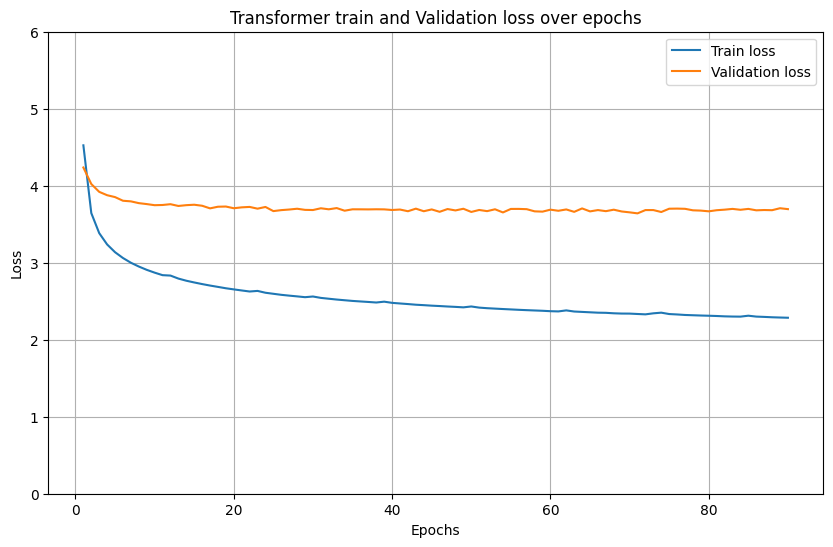

In [ ]:
plt.figure(figsize=(10,6))
plt.grid()

plt.plot(losses.Epoch, losses.Train_loss, label='Train loss')
plt.plot(losses.Epoch, losses.Val_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer train and Validation loss over epochs')

plt.ylim(ymin=0, ymax=6)

plt.legend()
plt.show()

In [ ]:
!wget -O 'checkpoint_epoch71.zip' $'https://www.dropbox.com/scl/fi/11l2xszm37k71f0kw1c8o/checkpoint_epoch71.zip?rlkey=lelx3ef0x08xmrsz8btmyhl4w&dl=0'
!unzip -q $'/content/checkpoint_epoch71.zip' -d $'/content/'
os.remove('/content/checkpoint_epoch71.zip')

--2024-02-21 18:21:38--  https://www.dropbox.com/scl/fi/11l2xszm37k71f0kw1c8o/checkpoint_epoch71.zip?rlkey=lelx3ef0x08xmrsz8btmyhl4w&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc46d388f7bc10697b752bf04efc.dl.dropboxusercontent.com/cd/0/inline/CNvZpBFhUT4TlJYndC2W1YvEHYZkEkjIgpcjWNw48MUjrPPwMIKdg4XnyCYpYnavb441nG_YrrZm8v_WjKCC7On3uTN5swzq6HwL4n4XzzNu1RmJ5qCQXABy-MKxD-tnpUIJFYODNjxmcokm1F-NMMWy/file# [following]
--2024-02-21 18:21:38--  https://uc46d388f7bc10697b752bf04efc.dl.dropboxusercontent.com/cd/0/inline/CNvZpBFhUT4TlJYndC2W1YvEHYZkEkjIgpcjWNw48MUjrPPwMIKdg4XnyCYpYnavb441nG_YrrZm8v_WjKCC7On3uTN5swzq6HwL4n4XzzNu1RmJ5qCQXABy-MKxD-tnpUIJFYODNjxmcokm1F-NMMWy/file
Resolving uc46d388f7bc10697b752bf04efc.dl.dropboxusercontent.com (uc46d388f7bc10697b752bf04efc.dl.dropboxusercontent.com)... 16

In [ ]:
weights_path = '/content/checkpoint_epoch71.pth'

checkpoint = torch.load(weights_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## 6. Calculate loss on test dataset

In [ ]:
# from datetime import datetime

# t0 = datetime.now()

# test_loss_meter = []
# for idx, batch in enumerate(test_loader):
#     image, caption, mask, enc_mask, _ = batch
#     model.eval()

#     image, caption, mask, enc_mask = image.to(device), caption.to(device), mask.to(device), enc_mask.to(device)
#     pred = model(image, caption[:, :-1], enc_mask, mask[:, :-1])
#     pred = pred.view(-1, len(vocab))
#     # preds.append(pred)
#     caption = caption[:, 1:].contiguous().view(-1)
#     test_loss = criterion(pred, caption)
#     test_loss_meter.append(test_loss.item())

# test_avg_loss = np.mean(test_loss_meter)

# print("Test loss: {:.5f}".format(test_avg_loss))
# dt = datetime.now() - t0
# print(f"Duration: {dt}")

## 7. Caption picture from custom dataset

In [ ]:
def show_image(img_tensor: Tensor, title: str = None):
    # Wyświetl obraz dany w formie tensora
    print(img_tensor.shape, img_tensor.min(), img_tensor.max())
    inv_normalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1/0.229, 1/0.224, 1/0.225])
    img_tensor = inv_normalize(img_tensor)
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.axis("tight")
    plt.axis("image")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
def make_caption(image, model):
    # get encoder output first
    image = image.unsqueeze(dim=0)
    enc_masks = torch.ones(1, 49).to(device)
    # setup initial decoder input
    dec_input_ids = torch.tensor([[test_dataset.vocab.get_stoi()["<BOS>"]]], device=device)
    dec_attn_mask = torch.ones_like(dec_input_ids, device=device)
    # now do the decoder loop
    for _ in range(MAX_SEQ_LENGTH):
        dec_output = model(
            image,
            dec_input_ids,
            enc_masks,
            dec_attn_mask,
        )
        # choose the best value
        prediction_id = torch.argmax(dec_output[:, -1, :], axis=-1)
        # append to decoder input
        dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1, 1)))
        # recreate mask
        dec_attn_mask = torch.ones_like(dec_input_ids)
        # exit when reach <EOS>
        if prediction_id == test_dataset.vocab.get_stoi()["<EOS>"]:
            break
    tokens = [vocab.get_itos()[i] for i in dec_input_ids[0, 1:]]
    tokens = [token for token in tokens if token not in ["<PAD>", "<EOS>"]]

    return tokens

torch.Size([3, 224, 224]) tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')


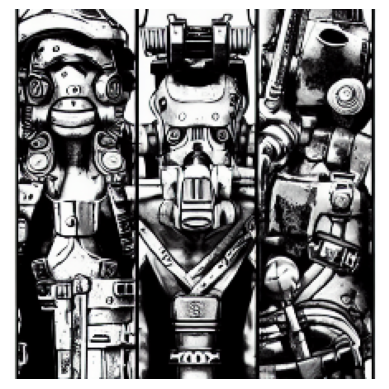

Pred prompt: cybermen
True prompt: fallout weapons kim jung gi black and white


In [ ]:
# Predict prompt for test dataset
model.eval()
with torch.no_grad():
    img, _, _, _, true_caption = test_dataset[25458]
    true_caption = true_caption.lower()
    img = img.to(device)
    caption = make_caption(img, model)
    caption = ' '.join(caption)
    show_image(img)
    print(f'Pred prompt: {caption}')
    print(f'True prompt: {true_caption}')

torch.Size([3, 224, 224]) tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')


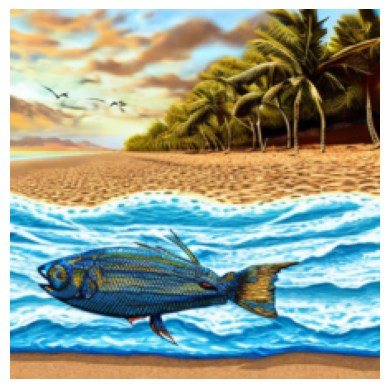

Pred prompt: a beautiful painting of a trout swimming in the ocean
True prompt: a fish running a marathon on the beach highly detailed


In [ ]:
# Predict prompt for custom dataset
model.eval()
with torch.no_grad():
    img, _, _, _, true_caption = custom_dataset[6]
    true_caption = true_caption.lower()
    img = img.to(device)
    caption = make_caption(img, model)
    caption = ' '.join(caption)
    show_image(img)
    print(f'Pred prompt: {caption}')
    print(f'True prompt: {true_caption}')

## 8. Create evaluation table for metrics calculation

In [ ]:
evaluation_dir = '/content/drive/MyDrive/projekt_gsn/evaluation/'

if not os.path.exists(losses_dir):
    os.mkdir(losses_dir)

In [ ]:
true_prompts = []
pred_prompts = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):

        img, _, _, _, true_prompt = test_dataset[i]

        img = img.to(device)
        pred_prompt = make_caption(img, model)
        pred_prompt = ' '.join(pred_prompt)

        true_prompts.append(true_prompt)
        pred_prompts.append(pred_prompt)

eval_table = pd.DataFrame(data={
                          'true_prompt':true_prompts,
                          'pred_prompt':pred_prompts
                          })

eval_table.to_csv(f'{evaluation_dir}transformer_evaluation_table.csv', index=False)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
eval_table

,true_prompt,pred_prompt
0,ben nevis by tyler edlin,a beautiful landscape of mountains and rivers ...
1,yellow wagtail,a yellow bird wearing a crown
2,yellow wagtail tyler edlin,a bird
3,captain marvel played by scarlett johansson,a still of scarlett johansson as captain america
4,generate anime girl hd vibrant smooth long hai...,marin kitagawa fanart marin kitagawa my dressu...
...,...,...
49995,david bowie giving a piggy back ride to ziggy ...,ziggy stardust as a anime character
49996,david bowie giving a piggy back ride to ziggy ...,david bowie as a ghostbuster in ghostbusters
49997,david bowie giving a piggy back ride to ziggy ...,scarlett johansson as a kenner style action fi...
49998,david bowie giving a piggy back ride to ziggy ...,a painting of giorno giovanna by tite kubo
